# Analysis of CPTAC Breast Cancer Patient Samples (Mertens 2016)

In [1]:
#Supporting packages for analysis
import numpy as np
import pandas as pd


#KSTAR imports
from kstar import config, helpers, calculate
from kstar.plot import DotPlot


#Set matplotlib defaults for arial 12 point font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12
import matplotlib.pyplot as plt


#where supplementary data was downloaded to (From https://figshare.com/articles/dataset/KSTAR_Supplementary_Data/14919726)
SUPPLEMENTS_DIR = './'

#Directory where KSTAR Supplemental data was set 
odir = SUPPLEMENTS_DIR+'Supplements/SupplementaryData/BreastCancer/CPTAC_Mertins2016/'

#load the Mann Whitney activities and FPR for Tyrosine predictions, 
#it will be faster and less data than loading all KSTAR outputs
activities = pd.read_csv(odir+'RESULTS/TCGA_Y_mann_whitney_activities.tsv', sep='\t', index_col=0)
fpr = pd.read_csv(odir+'RESULTS/TCGA_Y_mann_whitney_fpr.tsv', sep='\t', index_col=0)

s1 = pd.read_csv(odir+'brca_clinical_data_her2Determination_oneHeader.csv')



        
#load kinase map from supplementary data
KINASE_MAP =  pd.read_csv(SUPPLEMENTS_DIR+'SupplementaryData/Map/globalKinaseMap.csv', index_col = 0)
#set preferred kinase names from the kinase map (make a kinase_dict)
kinase_dict = {}
for kinase in activities.index:
    kinase_dict[kinase] = KINASE_MAP.loc[kinase,'Preferred Name']

## Plot using agglomerative clustering on both kinases and patients, and add context to each sample

In [2]:

#Setup a label dictionary that makes it easier to see patient sample names
mapDict = {}
cols = activities.columns
arr_Ids = []
for index, row in s1.iterrows():
    id_val = row['Complete TCGA ID']
    #remove the starting TCGA- or CPTAC- and find the match in the column header of data and map it
    patient = id_val.strip('TCGA-')
    patient = patient.strip('CPTAC-')
    mapDict[id_val] = '' #default if it's not found
    for col in cols:
        if patient in col:
            mapDict[id_val] = col
            break
    arr_Ids.append(mapDict[id_val])
    
s1['ID'] = arr_Ids

# Set the column labels to just have the labels
x_label_dict = {}
for label in cols:
    l = label.strip('data:patient:')
    l_arr = l.split('.')

    x_label_dict[label] = l_arr[0]
    

    

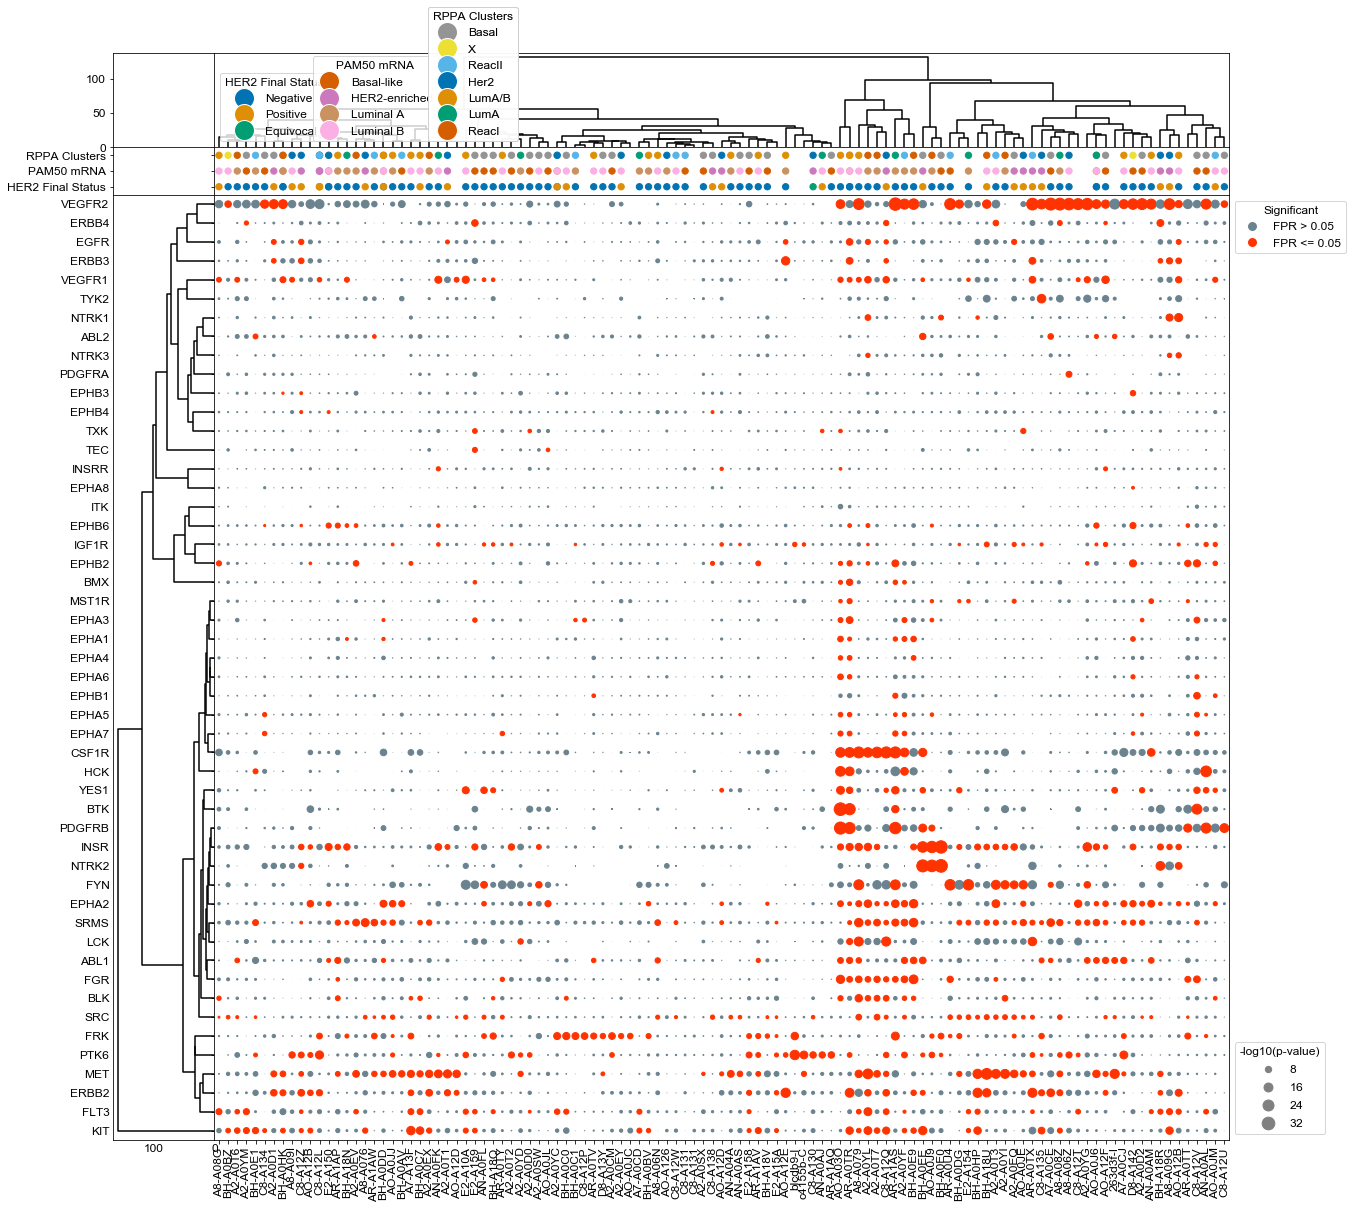

In [3]:
results = activities
results = -np.log10(results)


#Setup a figure with a context strip at the top for HER2 status and activity dots on the below axis
fig, axes = plt.subplots(figsize = (20, 20), 
        nrows = 3, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,0.05, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = DotPlot(results, 
               fpr, 
               figsize = (20,18), 
               dotsize = 5, 
               legend_title='-log10(p-value)', 
               x_label_dict=x_label_dict,
               kinase_dict = kinase_dict)
#dots.drop_kinases_with_no_significance()

#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
dots.cluster(orientation = 'left', ax = axes[2,0], method='ward')
dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')
#dots.context(ax=axes[1,1],info = s1, id_column = 'Sample', context_columns = ['Human Tumor Her2'], orientation = 'top', dotsize =200, markersize= 15 )
#dots.context(ax=axes[1,1],info = s1, id_column = 'ID', context_columns = ['AJCC Stage', 'HER2 Final Status', 'PAM50 mRNA'], orientation = 'top', dotsize =40, markersize= 20 )
dots.context(ax=axes[1,1],info = s1, id_column = 'ID', context_columns = ['HER2 Final Status', 'PAM50 mRNA', 'RPPA Clusters'], orientation = 'top', dotsize =40, markersize= 20 )

dots.dotplot(ax = axes[2,1])

plt.savefig(odir+'CPTAC_all.pdf', bbox_inches='tight')

## Plot ERBB2 activities with each samples associated HER2 status

In [4]:
s1['HER2 Status'] = s1['HER2 Final Status']

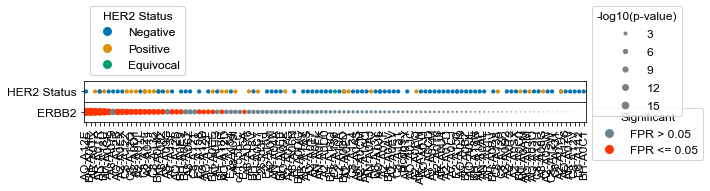

In [5]:
#Plot just the ERBB2 kinase activity and ERBB2 status

kinases = list(activities.index)
kinases.remove('ERBB2')
results = activities
results = results.sort_values('ERBB2', axis=1)

results = -np.log10(results)


#Setup a figure with a context strip at the top for HER2 status and activity dots on the below axis
fig, axes = plt.subplots(figsize = (9,0.75), 
        nrows = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.5,.5]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = dotplot.DotPlot(results, 
                       fpr, 
                       figsize = (9,0.75), 
                       dotsize = 3, 
                       legend_title='-log10(p-value)', 
                       x_label_dict=x_label_dict)

#drop all but ERBB2 
dots.drop_kinases(kinases)


dots.context(ax=axes[0],info = s1, id_column = 'ID', context_columns = ['HER2 Status'], orientation = 'top', dotsize =10, markersize= 10 )

dots.dotplot(ax = axes[1])


## Measure the number of cross-predictions between HER2-status and HER2/ERBB2 activity

In [9]:
def returnPredictionRates(kinasePred, s1):
    """
    Given a binary prediction of kinase status, what is the prediction rate
    """
    ERBB2_pred_dict = {}
    HER2_status_dict = {}
    for patient_ID in kinasePred.keys():
        if patient_ID in s1.ID.values:
            ERBB2_pred_dict[patient_ID] = kinasePred[patient_ID]
            status = s1[s1['ID']==patient_ID]['HER2 Final Status'].values[0]
            if status == 'Positive':
                HER2_status_dict[patient_ID] = True
            elif status == 'Negative':
                HER2_status_dict[patient_ID] = False
            else:
                HER2_status_dict[patient_ID] = 'Equivocal'
    comp_df = pd.DataFrame.from_dict(ERBB2_pred_dict, orient='index', columns =['HER2 Prediction'])
    temp = pd.DataFrame.from_dict(HER2_status_dict, orient='index', columns=['HER2 Status'])
    comp_df = comp_df.join(temp)
    trueNeg = 0
    truePos = 0
    falsePos = 0
    falseNeg = 0
    for index, row in comp_df.iterrows():
            if not row['HER2 Status']: #negative for HER2 at biopsy
                if not row['HER2 Prediction']:
                    trueNeg +=1
                else:
                    falsePos += 1
            else: #positive for HER2
                if not row['HER2 Prediction']:
                    falseNeg += 1
                else:
                    truePos +=1
    TPR = truePos/(truePos + falsePos)
    FPR = falsePos/(truePos+falsePos)
    return comp_df, [truePos, falsePos, trueNeg, falseNeg]

In [10]:

#generate the results, at a specific FPR, what % do we predict.
comp_df = {}
arrayDict ={}
alpha = 0.05
significance = fpr <= alpha
ERBB2_prediction = significance.loc['ERBB2']
comp_df, arrayVals = returnPredictionRates(ERBB2_prediction, s1)
[truePos, falsePos, trueNeg, falseNeg] = arrayVals

In [11]:
comp_df #the dataframe that combines the HER2 activity prediction and corresponding status

,HER2 Prediction,HER2 Status
data:patient:A2-A0CM.07TCGA,False,False
data:patient:A2-A0D0.06TCGA,False,False
data:patient:A2-A0D1.07TCGA,True,True
data:patient:A2-A0D2.31TCGA,False,False
data:patient:A2-A0EQ.08TCGA,False,True
...,...,...
data:patient:E2-A10A.02TCGA,False,False
data:patient:E2-A150.27TCGA,False,False
data:patient:E2-A154.03TCGA,False,False
data:patient:E2-A158.29TCGA,True,False


In [14]:
# HER2-negative patients that are predicted to have activity
HER2neg = comp_df[comp_df['HER2 Status']==False]
HER2neg
print('Number of HER2 Negative patients=%d, Number Considered HER2 active=%d'%(len(HER2neg), HER2neg['HER2 Prediction'].sum()))

Number of HER2 Negative patients=73, Number Considered HER2 active=12


In [15]:
# HER2-negative patients that are predicted to have activity
HER2pos = comp_df[comp_df['HER2 Status']==True]
print('Number of HER2 Positive patients=%d, Number Considered HER2 active=%d'%(len(HER2pos), HER2pos['HER2 Prediction'].sum()))

Number of HER2 Positive patients=23, Number Considered HER2 active=10


In [16]:
print("Check: there are %d patients and %d status"%(len(comp_df), truePos+trueNeg+falsePos+falseNeg))

Check: there are 97 patients and 97 status
